In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install sentinelhub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=eb9f4dc007d777049312cfdd28829dad3d90434505355b041c24572bcdd3cab6
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [4]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = '8a46c75d-0e4c-40d2-b00e-e0590ef758ae'
config.sh_client_id = '7ff19b34-1148-42c7-8c77-ba50981048bc'
config.sh_client_secret =  'O4JUyx6UjNhOuWPkYhrF1YNndo4WoSWs'


In [5]:

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest


In [5]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
# Exemple de BBOX sur le lac de la Gruyère :
coords_wgs84 = [7.02, 46.58, 7.15, 46.74]
#coords_wgs84 = [5.526123,45.775186,10.689697,47.827908] #switzerland
resolution = 30

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 30 m resolution: (346, 585) pixels


### Eval script to retrieve land surface temperature

In [7]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: { bands: 3 }
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [45]:
request_lst = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_lst,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
            #maxcc=0.1
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

To obtain parameters info

In [9]:
#help(SentinelHubRequest.input_data)

In [10]:
lst_imgs = request_lst.get_data()

Image type: uint8, 85


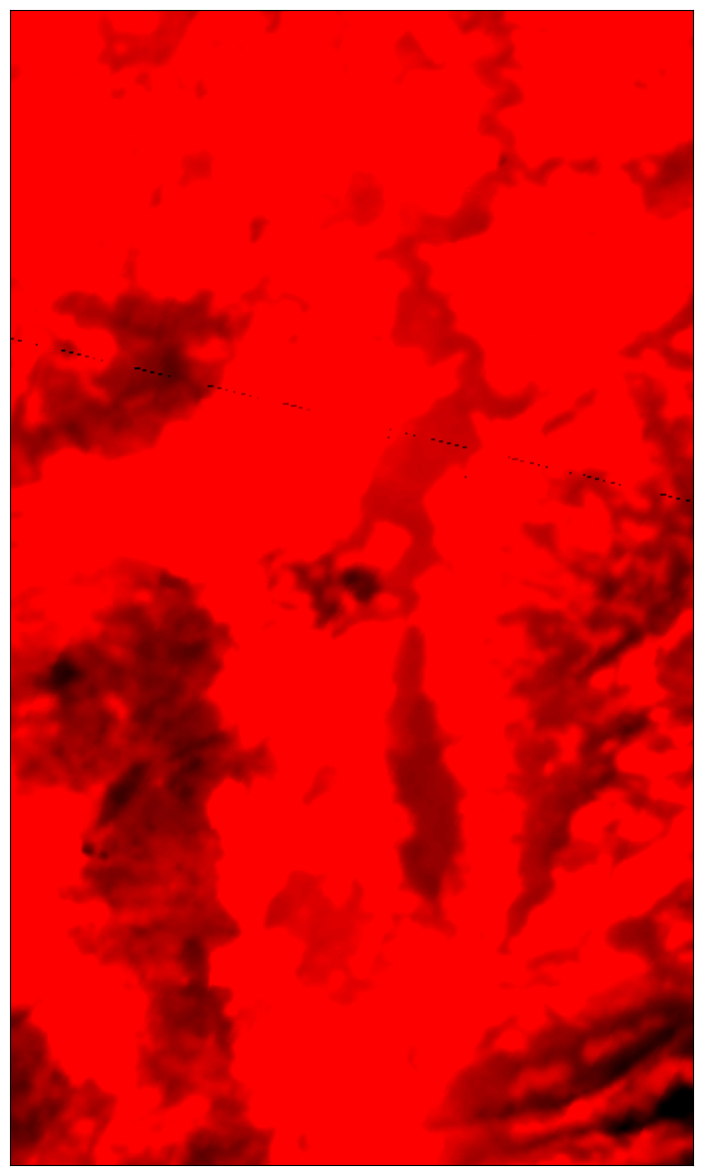

In [12]:
lst_image = lst_imgs[0]
print(f'Image type: {lst_image.dtype}, {lst_image.max()}')

# plot function
# factor 1/255 to scale between 0-1
# factor 6 to increase brightness
plot_image(lst_image, factor=6/255, clip_range=(0,1))

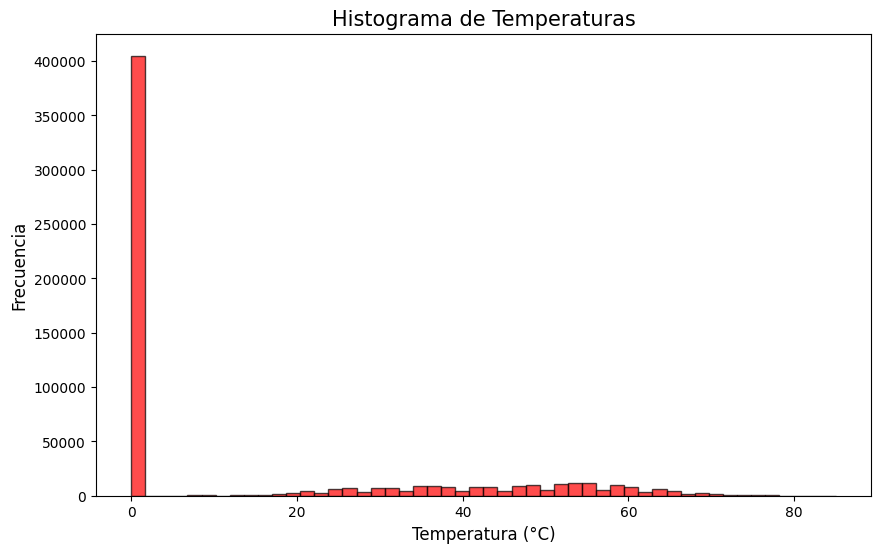

In [13]:

def plot_temperature_histogram(image, min_temp, max_temp, bins=50):
    """
    Esta función genera un histograma de los valores de temperatura en la imagen.
    """
    # Aplana la imagen en un array 1D
    flat_image = image.flatten()

    # Filtra los valores dentro del rango de temperaturas especificado (si es necesario)
    flat_image = flat_image[(flat_image >= min_temp) & (flat_image <= max_temp)]

    # Genera el histograma
    plt.figure(figsize=(10, 6))
    plt.hist(flat_image, bins=bins, color='red', edgecolor='black', alpha=0.7)

    # Añadir etiquetas y título
    plt.title('Histograma de Temperaturas', fontsize=15)
    plt.xlabel('Temperatura (°C)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Muestra el histograma
    plt.show()

# Llama a la función con los datos de la imagen y el rango de temperaturas
plot_temperature_histogram(lst_image, min_temp=np.min(lst_image), max_temp=np.max(lst_image), bins=50)

## Eval script for true color raw images

In [14]:
evalscript_raw_data = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_raw_data = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_raw_data,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

In [15]:
brute_imgs = request_raw_data.get_data()
brute_image = brute_imgs[0]

### Comparison

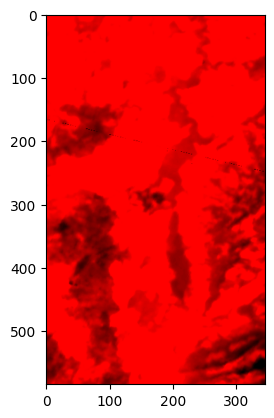

In [41]:
plt.imshow(np.clip(image2 * factor2, *clip_range2))

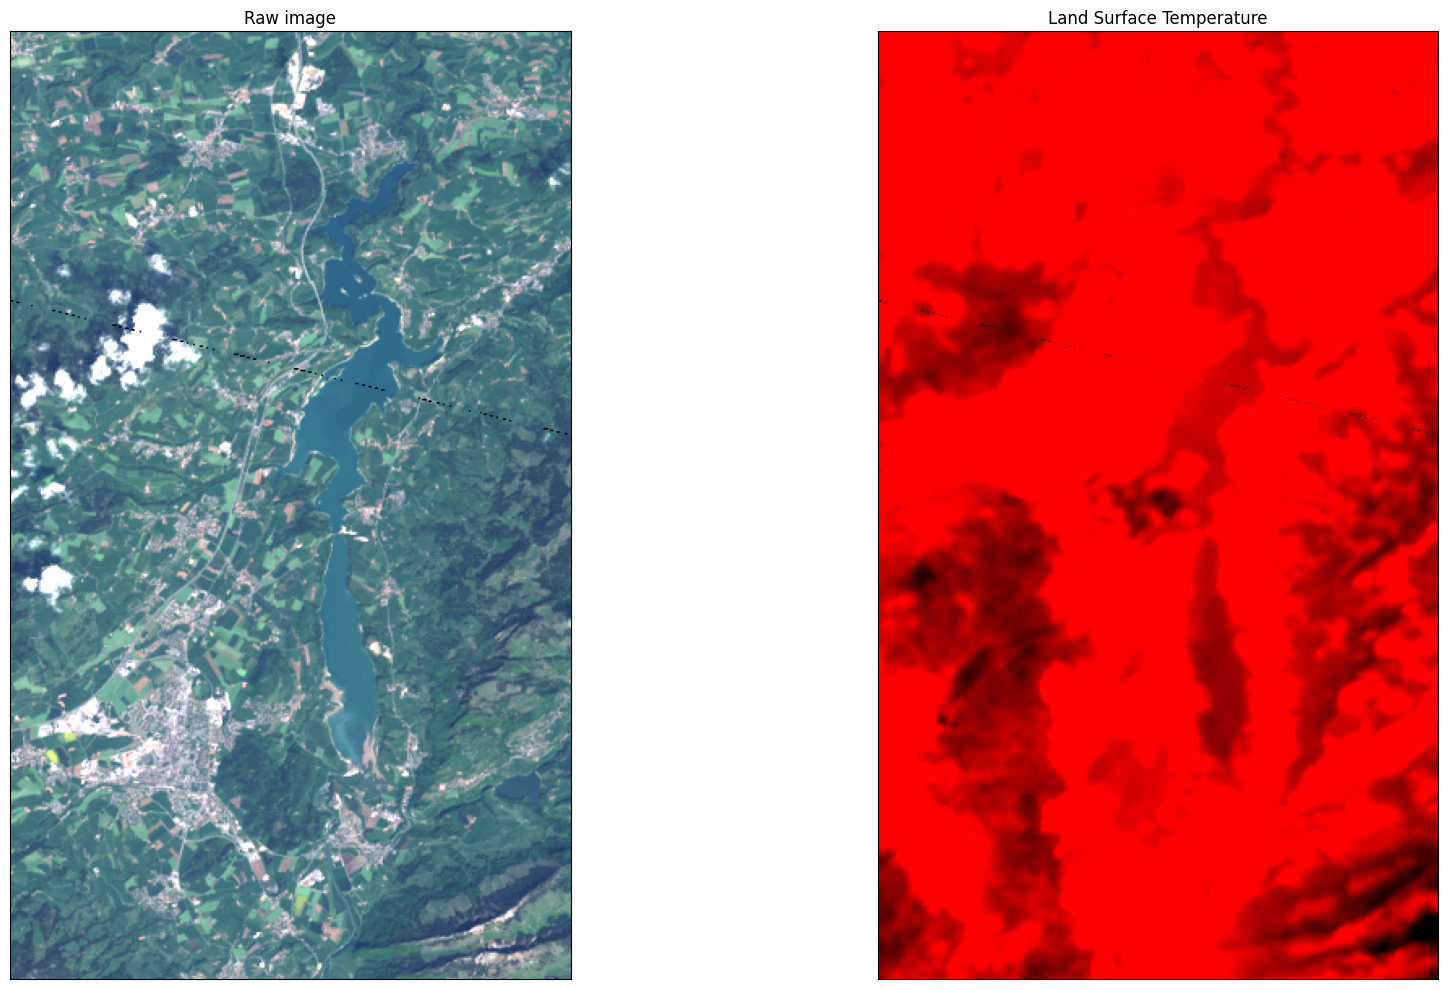

In [16]:
clip_range1=(0,1)
clip_range2=(0,1)

factor1=6/255
factor2=6/255

image1=brute_image
image2=lst_image

def plot_images_side_by_side(image1, image2, factor1=1.0, factor2=1.0, clip_range1=None, clip_range2=None, **kwargs1):
    """
    Función para plotear dos imágenes lado a lado.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Crear dos subplots

    # Plotear la primera imagen
    if clip_range1 is not None:
        axes[0].imshow(np.clip(image1 * factor1, *clip_range1), **kwargs1)
    else:
        axes[0].imshow(image1 * factor1, **kwargs1)
    axes[0].set_title('Raw image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plotear la segunda imagen
    if clip_range2 is not None:
        axes[1].imshow(np.clip(image2 * factor2, *clip_range2), **kwargs1)
    else:
        axes[1].imshow(image2 * factor2, **kwargs1)
    axes[1].set_title('Land Surface Temperature')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

# Llamada a la función con tus imágenes
plot_images_side_by_side(brute_image, lst_image, factor1, factor2, clip_range1, clip_range2)


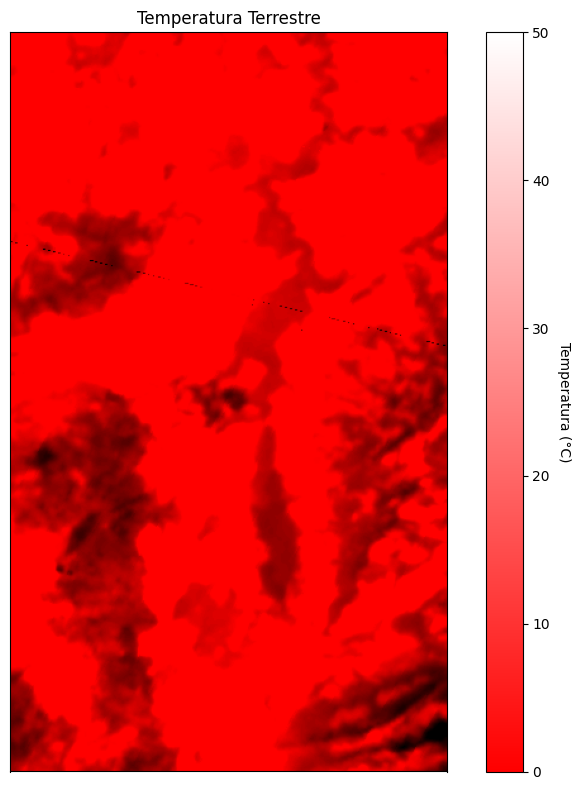

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_temperature_with_colorbar(land_temp, min_temp=0, max_temp=50, factor=1.0, clip_range=None):
    """
    Función para plotear la imagen de temperatura con una barra de color que corresponda al evalscript.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Mapa de colores personalizado (rojo a blanco)
    cmap = mcolors.LinearSegmentedColormap.from_list("RedWhite", ["red", "white"])

    # Configurar la normalización
    norm = mcolors.Normalize(vmin=min_temp, vmax=max_temp)

    # Aplicar el factor y el clip_range si se proporciona
    image_to_plot = land_temp * factor
    if clip_range is not None:
        image_to_plot = np.clip(image_to_plot, *clip_range)

    # Mostrar la imagen de temperatura
    im = ax.imshow(image_to_plot, cmap=cmap, norm=norm)
    ax.set_title('Temperatura Terrestre')
    ax.set_xticks([])
    ax.set_yticks([])

    # Añadir la barra de color con el rango correspondiente
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Temperatura (°C)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

# Llamar a la función con la imagen de temperatura generada por Sentinel Hub
plot_temperature_with_colorbar(lst_image, min_temp=0, max_temp=50, factor=factor1, clip_range=clip_range1)


## Monthly timestamps data

In [29]:
start = datetime.datetime(2010,1,1)
# end = datetime.datetime(2023,1,31)
n_month = 13

def first_day(month, year):
    return datetime.date(year, month, 1)

def last_day(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - datetime.timedelta(days=next_month.day)

slots = []
for month in range(1, 13):
    fd = first_day(month, 2010)
    ld = last_day(fd)
    slots.append( (fd.isoformat(), ld.isoformat()) )

slots

[('2010-01-01', '2010-01-31'),
 ('2010-02-01', '2010-02-28'),
 ('2010-03-01', '2010-03-31'),
 ('2010-04-01', '2010-04-30'),
 ('2010-05-01', '2010-05-31'),
 ('2010-06-01', '2010-06-30'),
 ('2010-07-01', '2010-07-31'),
 ('2010-08-01', '2010-08-31'),
 ('2010-09-01', '2010-09-30'),
 ('2010-10-01', '2010-10-31'),
 ('2010-11-01', '2010-11-30'),
 ('2010-12-01', '2010-12-31')]

In [30]:
def get_data_request(time_interval, evalscript=evalscript_lst):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.LANDSAT_OT_L1,
                time_interval=time_interval,
                mosaicking_order='leastCC',
                #maxcc=0.1
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )

In [31]:
# create a list of requests
list_of_requests = [get_data_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [23]:
len(data)

12

In [34]:
pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00


In [37]:
import numpy as np
from netCDF4 import Dataset
image_array=data[0]
with Dataset('imagen.nc', 'w', format='NETCDF4') as nc_file:
    # Crea dimensiones
    nc_file.createDimension('x', image_array.shape[0])
    nc_file.createDimension('y', image_array.shape[1])
    nc_file.createDimension('channels', image_array.shape[2])

    # Crea variables
    image_var = nc_file.createVariable('image', 'f4', ('x', 'y', 'channels'))

    # Asigna los datos
    image_var[:] = image_array

    # Opcional: agrega atributos
    nc_file.description = 'Archivo NetCDF con una imagen RGB'
    image_var.units = 'Unidad de la imagen (ejemplo)'

In [32]:
import zipfile
import os
from google.colab import files

directory = '/content'  # O el directorio que estés usando en Colab

# Nombre del archivo ZIP a crear
zip_filename = '/content/satellite_data.zip'

# Crear el archivo ZIP
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):  # Ajusta la extensión si es necesario
            file_path = os.path.join(directory, filename)
            zipf.write(file_path, arcname=filename)

files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = size[0] / size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 4.5/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()

### Adicionals

In [ ]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: [
          { id:"visualization", bands: 3 },
          { id:"raw_lst", bands: 1 }
        ]
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return {
        visualization: [viz.process(outLST)],
        raw_lst: [outLST]
      };
    }
"""

In [ ]:
request_lst = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_lst,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
            #maxcc=0.1
        )
    ],
    responses=[
        #SentinelHubRequest.output_response('default', MimeType.TIFF)
        SentinelHubRequest.output_response('visualization', MimeType.TIFF),  # Salida visualización RGB
        SentinelHubRequest.output_response('raw_lst', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

In [ ]:
lst_imgs[0]['visualization.tif']

In [ ]:
lst_avg_values = []

# Recorrer todas las imágenes en la respuesta (suponiendo que response contiene una lista de imágenes)
for lst_image in lst_imgs[0]['raw_lst.tif']:  # El índice 1 es para la capa raw_lst
    # Convertir la imagen LST a un array de numpy
    lst_array = np.array(lst_image)

    # Calcular el valor promedio de LST en la imagen
    lst_avg = np.mean(lst_array)

    # Almacenar el valor promedio
    lst_avg_values.append(lst_avg)

# Crear un gráfico de líneas de los valores promedio de LST
plt.figure(figsize=(10, 5))
plt.plot(lst_avg_values, marker='o', linestyle='-', color='b', label='Promedio LST')
plt.title('Evolución de LST a lo largo del tiempo')
plt.xlabel('Índice Temporal')
plt.ylabel('LST Promedio (°C)')
plt.legend()
plt.grid(True)
plt.show()


# Le boiron

In [7]:
# Exemple de BBOX sur le Boiron:
coords_wgs84 = [6.376052411433987, 46.47981613330913, 6.491362831062974, 46.5810982983339]
resolution = 30

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 30 m resolution: (307, 366) pixels
